In [1]:
!pip install -r /content/drive/MyDrive/DataScience_ArtificialIntelligence_Utils-master/machine_learning/requirements.txt

     |████████████████████████████████| 276kB 4.4MB/s 
     |████████████████████████████████| 358kB 32.3MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for minisom: filename=MiniSom-2.2.8-cp37-none-any.whl size=8604 sha256=162b1f57f4ae19b56b3bc3c037fa23fdbfefd39f64e91dd8e1c697dc0bd29105
  Stored in directory: /root/.cache/pip/wheels/78/7e/a8/435947263149d3b94fa65339751f8c65617c436b0bdfb29c7d
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=bf15b585a19a6c9ea0e3c353fd3dc50d589813364f8c313d8764359b58c42e1e
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491623 sha256=a19a68a3c3921171cd05f716244db3dc0f0cd9adbb57510937f22ad0d188f2a9
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
  Created wheel for ppscore: filename=ppscore-1.2.0-p

In [16]:

## for data
import numpy as np
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import ppscore

## for machine learning
from sklearn import preprocessing, impute, utils, linear_model, feature_selection, model_selection, metrics, decomposition, cluster, ensemble
import imblearn

## for deep learning
from tensorflow.keras import models, layers
import minisom

## for explainer
from lime import lime_tabular
import shap

## for geospatial
import folium
import geopy



###############################################################################
#                       DATA ANALYSIS                                         #
###############################################################################
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical and "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"



'''
Get a general overview of a dataframe.
:parameter
    :param dtf: dataframe - input data
    :param max_cat: num - mininum number of recognize column type
'''
def dtf_overview(dtf, max_cat=20, figsize=(10,5)):
    ## recognize column type
    dic_cols = {col:utils_recognize_type(dtf, col, max_cat=max_cat) for col in dtf.columns}
        
    ## print info
    len_dtf = len(dtf)
    print("Shape:", dtf.shape)
    print("-----------------")
    for col in dtf.columns:
        info = col+" --> Type:"+dic_cols[col]
        info = info+" | Nas: "+str(dtf[col].isna().sum())+"("+str(int(dtf[col].isna().mean()*100))+"%)"
        if dic_cols[col] == "cat":
            info = info+" | Categories: "+str(dtf[col].nunique())
        else:
            info = info+" | Min-Max: "+"({x})-({y})".format(x=str(int(dtf[col].min())), y=str(int(dtf[col].max())))
        if dtf[col].nunique() == len_dtf:
            info = info+" | Possible PK"
        print(info)
                
    ## plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    heatmap = dtf.isnull()
    for k,v in dic_cols.items():
        if v == "num":
            heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
        else:
            heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
    sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Dataset Overview')
    #plt.setp(plt.xticks()[1], rotation=0)
    plt.show()
    
    ## add legend
    print("\033[1;37;40m Categerocial \033[m", "\033[1;30;41m Numerical \033[m", "\033[1;30;47m NaN \033[m")



'''
Plots the frequency distribution of a dtf column.
:parameter
    :param dtf: dataframe - input data
    :param x: str - column name
    :param max_cat: num - max number of uniques to consider a numerical variable as categorical
    :param top: num - plot setting
    :param show_perc: logic - plot setting
    :param bins: num - plot setting
    :param quantile_breaks: tuple - plot distribution between these quantiles (to exclude outilers)
    :param box_logscale: logic
    :param figsize: tuple - plot settings
'''
def freqdist_plot(dtf, x, max_cat=20, top=20, show_perc=True, bins=100, quantile_breaks=(0,10), box_logscale=False, figsize=(10,5)):
    try:
        ## cat --> freq
        if utils_recognize_type(dtf, x, max_cat) == "cat":   
            ax = dtf[x].value_counts().head(top).sort_values().plot(kind="barh", figsize=figsize)
            totals = []
            for i in ax.patches:
                totals.append(i.get_width())
            if show_perc == False:
                for i in ax.patches:
                    ax.text(i.get_width()+.3, i.get_y()+.20, str(i.get_width()), fontsize=10, color='black')
            else:
                total = sum(totals)
                for i in ax.patches:
                    ax.text(i.get_width()+.3, i.get_y()+.20, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10, color='black')
            ax.grid(axis="x")
            plt.suptitle(x, fontsize=20)
            plt.show()
            
        ## num --> density
        else:
            fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
            fig.suptitle(x, fontsize=20)
            ### distribution
            ax[0].title.set_text('distribution')
            variable = dtf[x].fillna(dtf[x].mean())
            breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
            variable = variable[ (variable > breaks[quantile_breaks[0]]) & (variable < breaks[quantile_breaks[1]]) ]
            sns.distplot(variable, hist=True, kde=True, kde_kws={"shade":True}, ax=ax[0])
            des = dtf[x].describe()
            ax[0].axvline(des["25%"], ls='--')
            ax[0].axvline(des["mean"], ls='--')
            ax[0].axvline(des["75%"], ls='--')
            ax[0].grid(True)
            des = round(des, 2).apply(lambda x: str(x))
            box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
            ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=1))
            ### boxplot 
            if box_logscale == True:
                ax[1].title.set_text('outliers (log scale)')
                tmp_dtf = pd.DataFrame(dtf[x])
                tmp_dtf[x] = np.log(tmp_dtf[x])
                tmp_dtf.boxplot(column=x, ax=ax[1])
            else:
                ax[1].title.set_text('outliers')
                dtf.boxplot(column=x, ax=ax[1])
            plt.show()   
        
    except Exception as e:
        print("--- got error ---")
        print(e)



'''
Plots a bivariate analysis.
:parameter
    :param dtf: dataframe - input data
    :param x: str - column
    :param y: str - column
    :param max_cat: num - max number of uniques to consider a numerical variable as categorical
'''
def bivariate_plot(dtf, x, y, max_cat=20, figsize=(10,5)):
    try:
        ## num vs num --> stacked + scatter with density
        if (utils_recognize_type(dtf, x, max_cat) == "num") & (utils_recognize_type(dtf, y, max_cat) == "num"):
            ### stacked
            dtf_noNan = dtf[dtf[x].notnull()]  #can't have nan
            breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
            groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, duplicates='drop')])[y].agg(['mean','median','size'])
            fig, ax = plt.subplots(figsize=figsize)
            fig.suptitle(x+"   vs   "+y, fontsize=20)
            groups[["mean", "median"]].plot(kind="line", ax=ax)
            groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True, color="grey", alpha=0.3, grid=True)
            ax.set(ylabel=y)
            ax.right_ax.set_ylabel("Observazions in each bin")
            plt.show()
            ### joint plot
            sns.jointplot(x=x, y=y, data=dtf, dropna=True, kind='reg', height=int((figsize[0]+figsize[1])/2) )
            plt.show()

        ## cat vs cat --> hist count + hist %
        elif (utils_recognize_type(dtf, x, max_cat) == "cat") & (utils_recognize_type(dtf, y, max_cat) == "cat"):  
            fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=figsize)
            fig.suptitle(x+"   vs   "+y, fontsize=20)
            ### count
            ax[0].title.set_text('count')
            order = dtf.groupby(x)[y].count().index.tolist()
            sns.catplot(x=x, hue=y, data=dtf, kind='count', order=order, ax=ax[0])
            ax[0].grid(True)
            ### percentage
            ax[1].title.set_text('percentage')
            a = dtf.groupby(x)[y].count().reset_index()
            a = a.rename(columns={y:"tot"})
            b = dtf.groupby([x,y])[y].count()
            b = b.rename(columns={y:0}).reset_index()
            b = b.merge(a, how="left")
            b["%"] = b[0] / b["tot"] *100
            sns.barplot(x=x, y="%", hue=y, data=b, ax=ax[1]).get_legend().remove()
            ax[1].grid(True)
            ### fix figure
            plt.close(2)
            plt.close(3)
            plt.show()
    
        ## num vs cat --> density + stacked + boxplot 
        else:
            if (utils_recognize_type(dtf, x, max_cat) == "cat"):
                cat,num = x,y
            else:
                cat,num = y,x
            fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=figsize)
            fig.suptitle(x+"   vs   "+y, fontsize=20)
            ### distribution
            ax[0].title.set_text('density')
            for i in sorted(dtf[cat].unique()):
                sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
            ax[0].grid(True)
            ### stacked
            dtf_noNan = dtf[dtf[num].notnull()]  #can't have nan
            ax[1].title.set_text('bins')
            breaks = np.quantile(dtf_noNan[num], q=np.linspace(0,1,11))
            tmp = dtf_noNan.groupby([cat, pd.cut(dtf_noNan[num], breaks, duplicates='drop')]).size().unstack().T
            tmp = tmp[dtf_noNan[cat].unique()]
            tmp["tot"] = tmp.sum(axis=1)
            for col in tmp.drop("tot", axis=1).columns:
                tmp[col] = tmp[col] / tmp["tot"]
            tmp.drop("tot", axis=1)[sorted(dtf[cat].unique())].plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
            ### boxplot   
            ax[2].title.set_text('outliers')
            sns.catplot(x=cat, y=num, data=dtf, kind="box", ax=ax[2], order=sorted(dtf[cat].unique()))
            ax[2].grid(True)
            ### fix figure
            plt.close(2)
            plt.close(3)
            plt.show()
        
    except Exception as e:
        print("--- got error ---")
        print(e)
        


'''
Plots a bivariate analysis using Nan and not-Nan as categories.
'''
def nan_analysis(dtf, na_x, y, max_cat=20, figsize=(10,5)):
    dtf_NA = dtf[[na_x, y]]
    dtf_NA[na_x] = dtf[na_x].apply(lambda x: "Value" if not pd.isna(x) else "NA")
    bivariate_plot(dtf_NA, x=na_x, y=y, max_cat=max_cat, figsize=figsize)



'''
Plots a bivariate analysis with time variable.
'''
def ts_analysis(dtf, x, y, max_cat=20, figsize=(10,5)):
    if utils_recognize_type(dtf, y, max_cat) == "cat":
        dtf_tmp = dtf.groupby(x)[y].sum()       
    else:
        dtf_tmp = dtf.groupby(x)[y].median()
    dtf_tmp.plot(title=y+" by "+x, figsize=figsize, grid=True)


  
'''
plots multivariate analysis.
'''
def cross_distributions(dtf, x1, x2, y, max_cat=20, figsize=(10,5)):
    ## Y cat
    if utils_recognize_type(dtf, y, max_cat) == "cat":
        
        ### cat vs cat --> contingency table
        if (utils_recognize_type(dtf, x1, max_cat) == "cat") & (utils_recognize_type(dtf, x2, max_cat) == "cat"):
            cont_table = pd.crosstab(index=dtf[x1], columns=dtf[x2], values=dtf[y], aggfunc="sum")
            fig, ax = plt.subplots(figsize=figsize)
            sns.heatmap(cont_table, annot=True, fmt='.0f', cmap="YlGnBu", ax=ax, linewidths=.5).set_title(x1+'  vs  '+x2+'  (filter: '+y+')')
    
        ### num vs num --> scatter with hue
        elif (utils_recognize_type(dtf, x1, max_cat) == "num") & (utils_recognize_type(dtf, x2, max_cat) == "num"):
            sns.lmplot(x=x1, y=x2, data=dtf, hue=y, height=figsize[1])
        
        ### num vs cat --> boxplot with hue
        else:
            if (utils_recognize_type(dtf, x1, max_cat) == "cat"):
                cat,num = x1,x2
            else:
                cat,num = x2,x1
            fig, ax = plt.subplots(figsize=figsize)
            sns.boxplot(x=cat, y=num, hue=y, data=dtf, ax=ax).set_title(x1+'  vs  '+x2+'  (filter: '+y+')')
            ax.grid(True)
    
    ## Y num
    else:
        ### all num --> 3D scatter plot
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=figsize)
        ax = fig.gca(projection='3d')
        plot3d = ax.scatter(xs=dtf[x1], ys=dtf[x2], zs=dtf[y], c=dtf[y], cmap='inferno', linewidth=0.5)
        fig.colorbar(plot3d, shrink=0.5, aspect=5, label=y)
        ax.set(xlabel=x1, ylabel=x2, zlabel=y)
        plt.show()


     
'''
Moves columns into a dtf.
:parameter
    :param dtf: dataframe - input data
    :param lst_cols: list - names of the columns that must be moved
    :param where: str - "front" or "end"
:return
    dtf with moved columns
'''
def pop_columns(dtf, lst_cols, where="end"):
    current_cols = dtf.columns.tolist()
    for col in lst_cols:    
        current_cols.pop( current_cols.index(col) )
    if where == "front":
        dtf = dtf[lst_cols + current_cols]
    else:
        dtf = dtf[current_cols + lst_cols]
    return dtf



'''
Checks the primary key of a table and saves it as csv.
:parameter
    :param dtf: dataframe - input data
    :param pk: str - column name
    :param save: logic - want to save the file?
    :param path: str - dirpath
    :param dtf_name: str - csv name
:return
    the duplicated keys (in case pk is not unique)
'''
def CheckAndSave(dtf, pk, save=False, path=None, dtf_name=None):
    try:
        if len(dtf.index) == dtf[pk].nunique():
            print("Rows:", len(dtf.index), " = ", "Pk:", dtf[pk].nunique(), "--> OK")
            if save == True:
                dtf.to_csv(path_or_buf= path+dtf_name+".csv", sep=',', decimal=".", header=True, index=False)
                print("saved.")
        else:
            print("Rows:", len(dtf.index), " != ", "Pk:", dtf[pk].nunique(), "--> SHIT")
            ERROR = dtf.groupby(pk).size().reset_index(name= "count").sort_values(by="count", ascending= False)
            print("Example: ", pk+"==", ERROR.iloc[0,0])
            return dtf[ dtf[pk]==ERROR.iloc[0,0] ]
    
    except Exception as e:
        print("--- got error ---")
        print(e)



###############################################################################
#                         CORRELATION                                         #
###############################################################################        
'''
Computes the correlation matrix.
:parameter
    :param dtf: dataframe - input data
    :param method: str - "pearson" (numeric), "spearman" (categorical), "kendall"
    :param negative: bool - if False it takes the absolute values of correlation
    :param lst_filters: list - filter rows to show
    :param annotation: logic - plot setting
'''
def corr_matrix(dtf, method="pearson", negative=True, lst_filters=[], annotation=True, figsize=(10,5)):    
    ## factorize
    dtf_corr = dtf.copy()
    for col in dtf_corr.columns:
        if dtf_corr[col].dtype == "O":
            print("--- WARNING: Factorizing", dtf_corr[col].nunique(),"labels of", col, "---")
            dtf_corr[col] = dtf_corr[col].factorize(sort=True)[0]
    ## corr matrix
    dtf_corr = dtf_corr.corr(method=method) if len(lst_filters) == 0 else dtf_corr.corr(method=method).loc[lst_filters]
    dtf_corr = dtf_corr if negative is True else dtf_corr.abs()
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(dtf_corr, annot=annotation, fmt='.2f', cmap="YlGnBu", ax=ax, cbar=True, linewidths=0.5)
    plt.title(method + " correlation")
    return dtf_corr



'''
Computes the pps matrix.
'''
def pps_matrix(dtf, annotation=True, lst_filters=[], figsize=(10,5)):
    dtf_pps = ppscore.matrix(dtf) if len(lst_filters) == 0 else ppscore.matrix(dtf).Y
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(dtf_pps, vmin=0., vmax=1., annot=annotation, fmt='.2f', cmap="YlGnBu", ax=ax, cbar=True, linewidths=0.5)
    plt.title("predictive power score")
    return dtf_pps


    
'''
Computes correlation/dependancy and p-value (prob of happening something different than what observed in the sample)
'''
def test_corr(dtf, x, y, max_cat=20):
    ## num vs num --> pearson
    if (utils_recognize_type(dtf, x, max_cat) == "num") & (utils_recognize_type(dtf, y, max_cat) == "num"):
        dtf_noNan = dtf[dtf[x].notnull()]  #can't have nan
        coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
        coeff, p = round(coeff, 3), round(p, 3)
        conclusion = "Significant" if p < 0.05 else "Non-Significant"
        print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")
    
    ## cat vs cat --> cramer (chiquadro)
    elif (utils_recognize_type(dtf, x, max_cat) == "cat") & (utils_recognize_type(dtf, y, max_cat) == "cat"):
        cont_table = pd.crosstab(index=dtf[x], columns=dtf[y])
        chi2_test = scipy.stats.chi2_contingency(cont_table)
        chi2, p = chi2_test[0], chi2_test[1]
        n = cont_table.sum().sum()
        phi2 = chi2/n
        r,k = cont_table.shape
        phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
        rcorr = r-((r-1)**2)/(n-1)
        kcorr = k-((k-1)**2)/(n-1)
        coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
        coeff, p = round(coeff, 3), round(p, 3)
        conclusion = "Significant" if p < 0.05 else "Non-Significant"
        print("Cramer Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")
    
    ## num vs cat --> 1way anova (f: the means of the groups are different)
    else:
        if (utils_recognize_type(dtf, x, max_cat) == "cat"):
            cat,num = x,y
        else:
            cat,num = y,x
        model = smf.ols(num+' ~ '+cat, data=dtf).fit()
        table = sm.stats.anova_lm(model)
        p = table["PR(>F)"][0]
        coeff, p = None, round(p, 3)
        conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
        print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")
        
    return coeff, p



###############################################################################
#                       PREPROCESSING                                         #
###############################################################################
'''
Split the dataframe into train / test
'''
def dtf_partitioning(dtf, y, test_size=0.3, shuffle=False):
    dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=test_size, shuffle=shuffle) 
    print("X_train shape:", dtf_train.drop(y, axis=1).shape, "| X_test shape:", dtf_test.drop(y, axis=1).shape)
    print("y_train mean:", round(np.mean(dtf_train[y]),2), "| y_test mean:", round(np.mean(dtf_test[y]),2))
    print(dtf_train.shape[1], "features:", dtf_train.drop(y, axis=1).columns.to_list())
    return dtf_train, dtf_test



'''
Rebalances a dataset with up-sampling and down-sampling.
:parameter
    :param dtf: dataframe - feature matrix dtf
    :param y: str - column to use as target 
    :param balance: str - "up", "down", if None just prints some stats
    :param method: str - "random" for sklearn or "knn" for imblearn
    :param size: num - 1 for same size of the other class, 0.5 for half of the other class
:return
    rebalanced dtf
'''
def rebalance(dtf, y, balance=None,  method="random", replace=True, size=1):
    ## check
    print("--- situation ---")
    check = dtf[y].value_counts().to_frame()
    check["%"] = (check[y] / check[y].sum() *100).round(1).astype(str) + '%'
    print(check)
    print("tot:", check[y].sum())

    ## sklearn
    if balance is not None and method == "random":
        ### set the major and minor class
        major = check.index[0]
        minor = check.index[1]
        dtf_major = dtf[dtf[y]==major]
        dtf_minor = dtf[dtf[y]==minor]

        ### up-sampling
        if balance == "up":
            print("--- upsampling ---")
            print("   randomly replicate observations from the minority class (Overfitting risk)")
            dtf_minor = utils.resample(dtf_minor, replace=replace, random_state=123, n_samples=int(size*len(dtf_major)))
            dtf_balanced = pd.concat([dtf_major, dtf_minor])

        ### down-sampling
        elif balance == "down":
            print("--- downsampling ---")
            print("   randomly remove observations of the majority class (Underfitting risk)")
            dtf_minor = utils.resample(dtf_minor, replace=replace, random_state=123, n_samples=int(size*len(dtf_major)))
            dtf_balanced = pd.concat([dtf_major, dtf_minor])

    ## imblearn
    if balance is not None and method == "knn":
        ### up-sampling
        if balance == "up":
            print("--- upsampling ---")
            print("   create synthetic observations from the minority class (Distortion risk)")
            smote = imblearn.over_sampling.SMOTE(random_state=123)
            dtf_balanced, y_values = smote.fit_sample(dtf.drop(y,axis=1), y=dtf[y])
            dtf_balanced[y] = y_values
       
        ### down-sampling
        elif balance == "down":
            print("--- downsampling ---")
            print("   select observations that don't affect performance (Underfitting risk)")
            nn = imblearn.under_sampling.CondensedNearestNeighbour(random_state=123)
            dtf_balanced, y_values = nn.fit_sample(dtf.drop(y,axis=1), y=dtf[y])
            dtf_balanced[y] = y_values
        
    ## check rebalance
    if balance is not None:
        print("--- new situation ---")
        check = dtf_balanced[y].value_counts().to_frame()
        check["%"] = (check[y] / check[y].sum() *100).round(1).astype(str) + '%'
        print(check)
        print("tot:", check[y].sum())
        return dtf_balanced
    


'''
Replace Na with a specific value or mean for numerical and mode for categorical. 
'''
def fill_na(dtf, x, value=None):
    if value is None:
        value = dtf[x].mean() if utils_recognize_type(dtf, x) == "num" else dtf[x].mode().iloc[0]
        print("--- Replacing Nas with:", value, "---")
        dtf[x] = dtf[x].fillna(value)
        return dtf, value
    else:
        print("--- Replacing Nas with:", value, "---")
        dtf[x] = dtf[x].fillna(value)
        return dtf



'''
Transforms a categorical column into dummy columns
:parameter
    :param dtf: dataframe - feature matrix dtf
    :param x: str - column name
    :param dropx: logic - whether the x column should be dropped
:return
    dtf with dummy columns added
'''
def add_dummies(dtf, x, dropx=False):
    dtf_dummy = pd.get_dummies(dtf[x], prefix=x, drop_first=True, dummy_na=False)
    dtf = pd.concat([dtf, dtf_dummy], axis=1)
    print( dtf.filter(like=x, axis=1).head() )
    if dropx == True:
        dtf = dtf.drop(x, axis=1)
    return dtf
    


'''
Reduces the classes a categorical column.
:parameter
    :param dtf: dataframe - feature matrix dtf
    :param x: str - column name
    :param dic_clusters_mapping: dict - ex: {"min":[30,45,180], "max":[60,120], "mean":[]}  where the residual class must have an empty list
    :param dropx: logic - whether the x column should be dropped
'''
def add_feature_clusters(dtf, x, dic_clusters_mapping, dropx=False):
    dic_flat = {v:k for k,lst in dic_clusters_mapping.items() for v in lst}
    for k,v in dic_clusters_mapping.items():
        if len(v)==0:
            residual_class = k 
    dtf[x+"_cluster"] = dtf[x].apply(lambda x: dic_flat[x] if x in dic_flat.keys() else residual_class)
    if dropx == True:
        dtf = dtf.drop(x, axis=1)
    return dtf



'''
Scales features.
'''
def scaling(dtf, y, scalerX=None, scalerY=None, fitted=False, task="classification"):
    scalerX = preprocessing.MinMaxScaler(feature_range=(0,1)) if scalerX is None else scalerX
    if fitted is False:
        scalerX.fit(dtf.drop(y, axis=1))
    X = scalerX.transform(dtf.drop(y, axis=1))
    dtf_scaled = pd.DataFrame(X, columns=dtf.drop(y, axis=1).columns, index=dtf.index)
    if task == "regression":
        scalerY = preprocessing.MinMaxScaler(feature_range=(0,1)) if scalerY is None else scalerY
        dtf_scaled[y] = scalerY.fit_transform(dtf[y].values.reshape(-1,1)) if fitted is False else dtf[y]
        return dtf_scaled, scalerX, scalerY
    else:
        dtf_scaled[y] = dtf[y]
        return dtf_scaled, scalerX



'''
Computes all the required data preprocessing.
:parameter
    :param dtf: dataframe - feature matrix dtf
    :param y: str - name of the dependent variable 
    :param processNas: str or None - "mean", "median", "most_frequent"
    :param processCategorical: str or None - "dummies"
    :param split: num or None - test_size (example 0.2)
    :param scale: str or None - "standard", "minmax"
    :param task: str - "classification" or "regression"
:return
    dictionary with dtf, X_names lsit, (X_train, X_test), (Y_train, Y_test), scaler
'''
def data_preprocessing(dtf, y, processNas=None, processCategorical=None, split=None, scale=None, task="classification"):
    try:
        dtf = pop_columns(dtf, [y], "front")
        
        ## missing
        ### check
        print("--- check missing ---")
        if dtf.isna().sum().sum() != 0:
            cols_with_missings = []
            for col in dtf.columns.to_list():
                if dtf[col].isna().sum() != 0:
                    print("WARNING:", col, "-->", dtf[col].isna().sum(), "Nas")
                    cols_with_missings.append(col)
            ### treat
            if processNas is not None:
                print("...treating Nas...")
                cols_with_missings_numeric = []
                for col in cols_with_missings:
                    if dtf[col].dtype == "O":
                        print(col, "categorical --> replacing Nas with label 'missing'")
                        dtf[col] = dtf[col].fillna('missing')
                    else:
                        cols_with_missings_numeric.append(col)
                if len(cols_with_missings_numeric) != 0:
                    print("replacing Nas in the numerical variables:", cols_with_missings_numeric)
                imputer = impute.SimpleImputer(strategy=processNas)
                imputer = imputer.fit(dtf[cols_with_missings_numeric])
                dtf[cols_with_missings_numeric] = imputer.transform(dtf[cols_with_missings_numeric])
        else:
            print("   OK: No missing")
                
        ## categorical data
        ### check
        print("--- check categorical data ---")
        cols_with_categorical = []
        for col in dtf.columns.to_list():
            if dtf[col].dtype == "O":
                print("WARNING:", col, "-->", dtf[col].nunique(), "categories")
                cols_with_categorical.append(col)
        ### treat
        if len(cols_with_categorical) != 0:
            if processCategorical is not None:
                print("...trating categorical...")
                for col in cols_with_categorical:
                    print(col)
                    dtf = pd.concat([dtf, pd.get_dummies(dtf[col], prefix=col)], axis=1).drop([col], axis=1)
        else:
            print("   OK: No categorical")
        
        ## 3.split train/test
        print("--- split train/test ---")
        X = dtf.drop(y, axis=1).values
        Y = dtf[y].values
        if split is not None:
            X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=split, shuffle=False)
            print("X_train shape:", X_train.shape, " | X_test shape:", X_test.shape)
            print("y_train mean:", round(np.mean(y_train),2), " | y_test mean:", round(np.mean(y_test),2))
            print(X_train.shape[1], "features:", dtf.drop(y, axis=1).columns.to_list())
        else:
            print("   OK: step skipped")
            X_train, y_train, X_test, y_test = X, Y, None, None
        
        ## 4.scaling
        print("--- scaling ---")
        if scale is not None:
            scalerX = preprocessing.StandardScaler() if scale == "standard" else preprocessing.MinMaxScaler()
            X_train = scalerX.fit_transform(X_train)
            scalerY = 0
            if X_test is not None:
                X_test = scalerX.transform(X_test)
            if task == "regression":
                scalerY = preprocessing.StandardScaler() if scale == "standard" else preprocessing.MinMaxScaler()
                y_train = scalerY.fit_transform(y_train.reshape(-1,1))
            print("   OK: scaled all features")
        else:
            print("   OK: step skipped")
            scalerX, scalerY = 0, 0
        
        return {"dtf":dtf, "X_names":dtf.drop(y, axis=1).columns.to_list(), 
                "X":(X_train, X_test), "y":(y_train, y_test), "scaler":(scalerX, scalerY)}
    
    except Exception as e:
        print("--- got error ---")
        print(e)



###############################################################################
#                  FEATURES SELECTION                                         #
###############################################################################
'''
Performs features selections: by correlation (keeping the lowest p-value) and by lasso.
:prameter
    :param dtf: dataframe - feature matrix dtf
    :param y: str - name of the dependent variable
    :param top: num - number of top features
    :param task: str - "classification" or "regression"
:return
    dic with lists of features to keep.
'''     
def features_selection(dtf, y, top=10, task="classification", figsize=(20,10)):
    try:
        dtf_X = dtf.drop(y, axis=1)
        feature_names = dtf_X.columns
        
        ## p-value (one way anova F-test)
        model = feature_selection.f_classif if task=="classification" else feature_selection.f_regression
        selector = feature_selection.SelectKBest(score_func=model, k=top).fit(dtf_X.values, dtf[y].values)
        pvalue_selected_features = feature_names[selector.get_support()]
        
        ## regularization (classif-->lasso (l1), regr-->ridge (l2))
        model = linear_model.LogisticRegression(C=1, penalty="l1", solver='liblinear') if task=="classification" else linear_model.Ridge(alpha=1.0, fit_intercept=True)
        selector = feature_selection.SelectFromModel(estimator=model, max_features=top).fit(dtf_X.values, dtf[y].values)
        regularization_selected_features = feature_names[selector.get_support()]
        
        ## plot
        dtf_features = pd.DataFrame({"features":feature_names})
        dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
        dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
        dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
        dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
        dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
        dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
        dtf_features["method"] = dtf_features["method"].apply(lambda x: x.split()[0]+" + "+x.split()[1] if len(x.split())==2 else x)
        fig, ax = plt.subplots(figsize=figsize)
        sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), ax=ax, dodge=False)
               
        join_selected_features = list(set(pvalue_selected_features).intersection(regularization_selected_features))
        return {"p_value":pvalue_selected_features, "regularization":regularization_selected_features, "join":join_selected_features}
    
    except Exception as e:
        print("--- got error ---")
        print(e)



'''
Computes features importance.
:parameter
    :param X: array
    :param X_names: list
    :param model: model istance (after fitting)
    :param figsize: tuple - plot setting
:return
    dtf with features importance
'''
def features_importance(X, y, X_names, model=None, task="classification", figsize=(10,10)):
    ## model
    if model is None:
        if task == "classification":
            model = ensemble.GradientBoostingClassifier()  
        elif task == "regression":
            model = ensemble.GradientBoostingRegressor()
    model.fit(X,y)
    print("--- model used ---")
    print(model)
    
    ## importance dtf
    importances = model.feature_importances_
    dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":X_names}).sort_values("IMPORTANCE", ascending=False)
    dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
    dtf_importances = dtf_importances.set_index("VARIABLE")
    
    ## plot
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
    fig.suptitle("Features Importance", fontsize=20)
    ax[0].title.set_text('variables')
    dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
    ax[0].set(ylabel="")
    ax[1].title.set_text('cumulative')
    dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
    ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), xticklabels=dtf_importances.index)
    plt.xticks(rotation=70)
    plt.grid(axis='both')
    plt.show()
    return dtf_importances.reset_index()



###############################################################################
#                   MODEL DESIGN & TESTING - CLASSIFICATION                   #
###############################################################################
'''
Fits a sklearn classification model.
:parameter
    :param model: model object - model to fit (before fitting)
    :param X_train: array
    :param y_train: array
    :param X_test: array
    :param threshold: num - predictions > threshold are 1, otherwise 0 (only for classification)
:return
    model fitted and predictions
'''
def fit_ml_classif(model, X_train, y_train, X_test, threshold=0.5):
    ## model
    model = ensemble.GradientBoostingClassifier() if model is None else model
    
    ## train/test
    model.fit(X_train, y_train)
    predicted_prob = model.predict_proba(X_test)[:,1]
    predicted = (predicted_prob > threshold)
    return model, predicted_prob, predicted



'''
Perform k-fold validation.
'''
def utils_kfold_roc(model, X, y, cv=10, figsize=(10,5)):
    cv = model_selection.StratifiedKFold(n_splits=cv, shuffle=True)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0,1,100)
    fig = plt.figure(figsize=figsize)
    
    i = 1
    for train, test in cv.split(X, y):
        prediction = model.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, t = metrics.roc_curve(y[test], prediction[:, 1])
        tprs.append(scipy.interp(mean_fpr, fpr, tpr))
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i = i+1
        
    plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('K-Fold Validation')
    plt.legend(loc="lower right")
    plt.show()



'''
Find the best classif threshold for metrics: accuracy, precision, recall, f1
'''
def utils_threshold_selection(model, X, y, figsize=(10,5)):
    ## calculate scores for different thresholds
    dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
    XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X, y, test_size=0.2)
    predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1] #if "tensorflow" not in type(model) else model.fit(XX_train, yy_train, batch_size=32, epochs=100, verbose=0).model.predict(XX_test)
    thresholds = []
    for threshold in np.arange(0.1, 1, step=0.1):
        predicted = (predicted_prob > threshold)
        thresholds.append(threshold)
        dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
        dic_scores["precision"].append(metrics.precision_score(yy_test, predicted))
        dic_scores["recall"].append(metrics.recall_score(yy_test, predicted))
        dic_scores["f1"].append(metrics.f1_score(yy_test, predicted))
    
    ## find best
    dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
    for k in dic_scores.keys():
        print(k, "--> best threshold:", round(dtf_scores[dtf_scores[k]==dtf_scores[k].max()][k].index[0], 1))
        
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Threshold Selection", xlabel="Threshold", ylabel="Scores")
    dtf_scores.plot(ax=ax)
    plt.show()



'''
Tunes the hyperparameters of a sklearn classification model.
:parameter
    :param model_base: model object - model istance to tune (before fitting)
    :param param_dic: dict - dictionary of parameters to tune
    :param X_train: array - feature matrix
    :param y_train: array - y vector
    :param scoring: string - "roc_auc", "accuracy", "f1", "precision", "recall"
    :param searchtype: string - "RandomSearch" or "GridSearch"
:return
    model with hyperparams tuned
'''
def tune_classif_model(X_train, y_train, model_base=None, param_dic=None, scoring="f1", searchtype="RandomSearch", n_iter=1000, cv=10, figsize=(10,5)):
    ## params
    model_base = ensemble.GradientBoostingClassifier() if model_base is None else model_base
    param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750], 'max_depth':[2,3,4,5,6,7]} if param_dic is None else param_dic                        
    dic_scores = {'accuracy':metrics.make_scorer(metrics.accuracy_score), 'precision':metrics.make_scorer(metrics.precision_score), 
                  'recall':metrics.make_scorer(metrics.recall_score), 'f1':metrics.make_scorer(metrics.f1_score)}
    
    ## Search
    print("---", searchtype, "---")
    if searchtype == "RandomSearch":
        random_search = model_selection.RandomizedSearchCV(model_base, param_distributions=param_dic, n_iter=n_iter, scoring=dic_scores, refit=scoring).fit(X_train, y_train)
        print("Best Model parameters:", random_search.best_params_)
        print("Best Model "+scoring+":", round(random_search.best_score_, 2))
        model = random_search.best_estimator_
        
    elif searchtype == "GridSearch":
        grid_search = model_selection.GridSearchCV(model_base, param_dic, scoring=dic_scores, refit=scoring).fit(X_train, y_train)
        print("Best Model parameters:", grid_search.best_params_)
        print("Best Model mean "+scoring+":", round(grid_search.best_score_, 2))
        model = grid_search.best_estimator_
    
    ## K fold validation
    print("")
    print("--- Kfold Validation ---")
    Kfold_base = model_selection.cross_validate(estimator=model_base, X=X_train, y=y_train, cv=cv, scoring=dic_scores)
    Kfold_model = model_selection.cross_validate(estimator=model, X=X_train, y=y_train, cv=cv, scoring=dic_scores)
    for score in dic_scores.keys():
        print(score, "mean - base model:", round(Kfold_base["test_"+score].mean(),2), " --> best model:", round(Kfold_model["test_"+score].mean()))
    utils_kfold_roc(model, X_train, y_train, cv=cv, figsize=figsize)
    
    ## Threshold analysis
    print("")
    print("--- Threshold Selection ---")
    utils_threshold_selection(model, X_train, y_train, figsize=figsize)
    
    return model



'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()



'''
Fits a keras artificial/deep neural network.
:parameter
    :param X_train: array
    :param y_train: array
    :param X_test: array
    :param batch_size: num - keras batch
    :param epochs: num - keras epochs
    :param threshold: num - predictions > threshold are 1, otherwise 0
:return
    model fitted and predictions
'''
def fit_dl_classif(X_train, y_train, X_test, model=None, batch_size=32, epochs=100, threshold=0.5):
    ## model
    if model is None:
        ### define F1 metrics for Keras
        def Recall(y, y_hat):
            true_positives = K.sum(K.round(K.clip(y * y_hat, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def Precision(y, y_hat):
            true_positives = K.sum(K.round(K.clip(y * y_hat, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_hat, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

        def F1(y, y_hat):
            precision = Precision(y, y_hat)
            recall = Recall(y, y_hat)
            return 2*((precision*recall)/(precision+recall+K.epsilon()))

        ### build ann
        n_features = X_train.shape[1]
        n_neurons = int(round((n_features + 1)/2))
        model = models.Sequential([
            layers.Dense(input_dim=n_features, units=n_neurons, kernel_initializer='uniform', activation='relu'),
            layers.Dropout(rate=0.2),
            layers.Dense(units=n_neurons, kernel_initializer='uniform', activation='relu'),
            layers.Dropout(rate=0.2),
            layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid') ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',F1])
        print(model.summary())
    
    ## train
    verbose = 0 if epochs > 1 else 1
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = training.model.predict(X_test)
    predicted = (predicted_prob > threshold)
    return training.model, predicted_prob, predicted



'''
Evaluates a model performance.
:parameter
    :param y_test: array
    :param predicted: array
    :param predicted_prob: array
    :param show_thresholds: bool - if True annotates thresholds on the curves
'''
def evaluate_classif_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    
    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in classes]))
       
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax[0], cmap=plt.cm.Blues, cbar=False)
    ax[0].set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax[0].set_yticklabels(labels=classes, rotation=0)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)    
    ax[1].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(fpr, tpr))
    ax[1].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1].hlines(y=recall, xmin=-0.05, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[1].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
    ax[1].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
    ax[2].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(recalls, precisions))
    ax[2].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
    ax[2].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[2].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
    ax[2].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[2].legend(loc="lower left")
    ax[2].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)

    plt.show()
     


###############################################################################
#                   MODEL DESIGN & TESTING - REGRESSION                       #
###############################################################################
'''
Fits a sklearn regression model.
:parameter
    :param model: model object - model to fit (before fitting)
    :param X_train: array
    :param y_train: array
    :param X_test: array
    :param scalerY: scaler object (only for regression)
:return
    model fitted and predictions
'''
def fit_ml_regr(model, X_train, y_train, X_test, scalerY=None):  
    ## model
    model = ensemble.GradientBoostingRegressor() if model is None else model
    
    ## train/test
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    if scalerY is not None:
        predicted = scalerY.inverse_transform(predicted.reshape(-1,1)).reshape(-1)
    return model, predicted



'''
Tunes the hyperparameters of a sklearn regression model.
'''
def tune_regr_model(X_train, y_train, model_base=None, param_dic=None, scoring="r2", searchtype="RandomSearch", n_iter=1000, cv=10, figsize=(10,5)):
    model_base = ensemble.GradientBoostingRegressor() if model_base is None else model_base
    param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750], 'max_depth':[2,3,4,5,6,7]} if param_dic is None else param_dic                        

    ## Search
    print("---", searchtype, "---")
    if searchtype == "RandomSearch":
        random_search = model_selection.RandomizedSearchCV(model_base, param_distributions=param_dic, n_iter=n_iter, scoring=scoring).fit(X_train, y_train)
        print("Best Model parameters:", random_search.best_params_)
        print("Best Model "+scoring+":", round(random_search.best_score_, 2))
        model = random_search.best_estimator_
    
    elif searchtype == "GridSearch":
        grid_search = model_selection.GridSearchCV(model_base, param_dic, scoring=scoring).fit(X_train, y_train)
        print("Best Model parameters:", grid_search.best_params_)
        print("Best Model mean "+scoring+":", round(grid_search.best_score_, 2))
        model = grid_search.best_estimator_
    
    ## K fold validation
    print("")
    print("--- Kfold Validation ---")
    Kfold_base = model_selection.cross_validate(estimator=model_base, X=X_train, y=y_train, cv=cv, scoring=scoring)
    Kfold_model = model_selection.cross_validate(estimator=model, X=X_train, y=y_train, cv=cv, scoring=scoring)
    print(scoring, "mean - base model:", round(Kfold_base["test_score"].mean(),2), " --> best model:", round(Kfold_model["test_score"].mean()))
    
    scores = []
    cv = model_selection.KFold(n_splits=cv, shuffle=True)
    fig = plt.figure(figsize=figsize)
    i = 1
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train], y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()
    
    return model



'''
Fits a keras deep/artificial neural network.
:parameter
    :param X_train: array
    :param y_train: array
    :param X_test: array
    :param batch_size: num - keras batch
    :param epochs: num - keras epochs
    :param scalerY: scaler object (only for regression)
:return
    model fitted and predictions
'''
def fit_dl_regr(X_train, y_train, X_test, scalerY, model=None, batch_size=32, epochs=100):
    ## model
    if model is None:
        ### define R2 metric for Keras
        from tensorflow.keras import backend as K
        def R2(y, y_hat):
            ss_res =  K.sum(K.square(y - y_hat)) 
            ss_tot = K.sum(K.square(y - K.mean(y))) 
            return ( 1 - ss_res/(ss_tot + K.epsilon()) )

        ### build ann
        n_features = X_train.shape[1]
        n_neurons = int(round((n_features + 1)/2))
        model = models.Sequential([
            layers.Dense(input_dim=n_features, units=n_neurons, kernel_initializer='normal', activation='relu'),
            layers.Dropout(rate=0.2),
            layers.Dense(units=n_neurons, kernel_initializer='normal', activation='relu'),
            layers.Dropout(rate=0.2),
            layers.Dense(units=1, kernel_initializer='normal', activation='linear') ])
        model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[R2])
        print(model.summary())

    ## train
    verbose = 0 if epochs > 1 else 1
    training = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted = training.model.predict(X_test)
    if scalerY is not None:
        predicted = scalerY.inverse_transform(predicted)
    return training.model, predicted.reshape(-1)



'''
Evaluates a model performance.
:parameter
    :param y_test: array
    :param predicted: array
'''
def evaluate_regr_model(y_test, predicted, figsize=(25,5)):
    ## Kpi
    print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
    
    ## residuals
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))
    
    ## Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    from statsmodels.graphics.api import abline_plot
    ax[0].scatter(predicted, y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()
    
    ## Plot predicted vs residuals
    ax[1].scatter(predicted, residuals, color="red")
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
    ax[1].legend()
    
    ## Plot residuals distribution
    sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax[2], label="mean = "+"{:,.0f}".format(np.mean(residuals)))
    ax[2].grid(True)
    ax[2].set(yticks=[], yticklabels=[], title="Residuals distribution")
    plt.show()



###############################################################################
#                       EXPLAINABILITY                                        #
###############################################################################
'''
Use shap to build an a explainer.
:parameter
    :param model: model instance (after fitting)
    :param X_names: list
    :param X_instance: array of size n x 1 (n,)
    :param X_train: array - if None the model is simple machine learning, if not None then it's a deep learning model
    :param task: string - "classification", "regression"
    :param top: num - top features to display
:return
    dtf with explanations
'''
def explainer_shap(model, X_names, X_instance, X_train=None, task="classification", top=10):
    ## create explainer
    ### machine learning
    if X_train is None:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_instance)
    ### deep learning
    else:
        explainer = shap.DeepExplainer(model, data=X_train[:100])
        shap_values = explainer.shap_values(X_instance.reshape(1,-1))[0].reshape(-1)

    ## plot
    ### classification
    if task == "classification":
        shap.decision_plot(explainer.expected_value, shap_values, link='logit', feature_order='importance',
                           features=X_instance, feature_names=X_names, feature_display_range=slice(-1,-top-1,-1))
    ### regression
    else:
        shap.waterfall_plot(explainer.expected_value[0], shap_values, 
                            features=X_instance, feature_names=X_names, max_display=top)



'''
Use lime to build an a explainer.
:parameter
    :param X_train: array
    :param X_names: list
    :param model: model instance (after fitting)
    :param Y_train: array
    :param X_instance: array of size n x 1 (n,)
    :param task: string - "classification", "regression"
    :param top: num - top features to display
:return
    dtf with explanations
'''
def explainer_lime(X_train, X_names, model, y_train, X_instance, task="classification", top=10):
    if task == "classification":
        explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names=np.unique(y_train), mode=task)
        explained = explainer.explain_instance(X_instance, model.predict_proba, num_features=top)
        dtf_explainer = pd.DataFrame(explained.as_list(), columns=['feature','effect'])
        explained.as_pyplot_figure()
        
    elif task == "regression":
        explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names="Y", mode=task)
        explained = explainer.explain_instance(X_instance, model.predict, num_features=top)
        dtf_explainer = pd.DataFrame(explained.as_list(), columns=['feature','effect'])
        explained.as_pyplot_figure()
    
    return dtf_explainer



###############################################################################
#                     VISUALIZE MODELS                                        #
###############################################################################
'''
Decomposes the feture matrix of train and test.
:parameter
    :param X_train: array
    :param X_test: array
    :param n_features: num - how many dimensions you want
:return
    dict with new train and test, and the model 
'''
def utils_dimensionality_reduction(X_train, X_test, n_features=2):
    model = decomposition.PCA(n_components=n_features)
    X_train = model.fit_transform(X_train)
    X_test = model.transform(X_test)
    return X_train, X_test, model



'''
Plots a 2d classification model result.
:parameter
    :param X_train: array
    :param y_train: array
    :param X_test: array
    :param y_test: array
    :param model: model istance (before fitting)
'''
def plot2d_classif_model(X_train, y_train, X_test, y_test, model=None, annotate=False, figsize=(10,5)):
    ## n features > 2d
    if X_train.shape[1] > 2:
        print("--- reducing dimensions to 2 ---")
        X_train, X_test, pca = utils_dimensionality_reduction(X_train, X_test, n_features=2)
     
    ## fit 2d model
    print("--- fitting 2d model ---")
    model_2d = ensemble.GradientBoostingClassifier() if model is None else model
    model_2d.fit(X_train, y_train)
    
    ## plot predictions
    print("--- plotting test set ---")
    from matplotlib.colors import ListedColormap
    colors = {np.unique(y_test)[0]:"black", np.unique(y_test)[1]:"green"}
    X1, X2 = np.meshgrid(np.arange(start=X_test[:,0].min()-1, stop=X_test[:,0].max()+1, step=0.01),
                         np.arange(start=X_test[:,1].min()-1, stop=X_test[:,1].max()+1, step=0.01))
    fig, ax = plt.subplots(figsize=figsize)
    Y = model_2d.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax.contourf(X1, X2, Y, alpha=0.5, cmap=ListedColormap(list(colors.values())))
    ax.set(xlim=[X1.min(),X1.max()], ylim=[X2.min(),X2.max()], title="Classification regions")
    for i in np.unique(y_test):
        ax.scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], c=colors[i], label="true "+str(i))  
    if annotate is True:
        for n,i in enumerate(y_test):
            ax.annotate(n, xy=(X_test[n,0], X_test[n,1]), textcoords='offset points', ha='left', va='bottom')
    plt.legend()
    plt.show()
    

    
'''
Plot 3d regression plane.
'''
def plot3d_regr_model(X_train, y_train, X_test, y_test, scalerY=None, model=None, rotate=(0,0), figsize=(10,5)):
    ## n features > 2d
    if X_train.shape[1] > 2:
        print("--- reducing dimensions to 3 ---")
        X_train, X_test, pca  = utils_dimensionality_reduction(X_train, X_test, n_features=2)
    
    ## fit 2d model
    print("--- fitting 2d model ---")
    model_2d = linear_model.LinearRegression() if model is None else model
    model_2d.fit(X_train, y_train)
    
    ## plot predictions
    print("--- plotting test set ---")
    from mpl_toolkits.mplot3d import Axes3D
    ax = Axes3D(plt.figure(figsize=figsize), elev=rotate[0], azim=rotate[1])
    ax.scatter(X_test[:,0], X_test[:,1], y_test, color="black")
    X1 = np.array([[X_test.min(), X_test.min()], [X_test.max(), X_test.max()]])
    X2 = np.array([[X_test.min(), X_test.max()], [X_test.min(), X_test.max()]])
    Y = model_2d.predict(np.array([[X_test.min(), X_test.min(), X_test.max(), X_test.max()], 
                                   [X_test.min(), X_test.max(), X_test.min(), X_test.max()]]).T).reshape((2,2))
    Y = scalerY.inverse_transform(Y) if scalerY is not None else Y
    ax.plot_surface(X1, X2, Y, alpha=0.5)
    ax.set(zlabel="Y", title="Regression plane", xticklabels=[], yticklabels=[])
    plt.show()



'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    for layer in model.layers:
        if "drop" in layer.name:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0} 
        else:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]} 
        lst_layers.append(dic_layer)
    return lst_layers



'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, titles=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes, layer_infos = [], []
    for i,layer in enumerate(lst_layers):
        if "drop" not in layer["name"]:
            layer_sizes.append(layer["in"] if i==0 else layer["out"])
            layer_infos.append( (layer["activation"], layer["params"], layer["bias"]) )
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title="Neural Network structure")
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        
        ### add titles
        if titles is True:
            if i == 0:
                plt.text(x=left, y=top, fontsize=10, s="Input layer")
                plt.text(x=left, y=top-p, fontsize=8, s="activation: "+str(layer_infos[i][0]))
                plt.text(x=left, y=top-2*p, fontsize=8,
                         s="inputs:"+str(layer_infos[i][1].shape[0]))
            elif i == len(layer_sizes)-1:
                plt.text(x=right, y=top, fontsize=10, s="Output layer")
                plt.text(x=right, y=top-p, fontsize=8, s="activation: "+str(layer_infos[i][0]))
                plt.text(x=right, y=top-2*p, fontsize=8,
                         s="output:"+str(layer_infos[i][1].shape[1])+" comb + bias")
            else:
                plt.text(x=left+i*x_space, y=top, fontsize=10, s="Hidden layer "+str(i))
                plt.text(x=left+i*x_space, y=top-p, fontsize=8, s="activation: "+str(layer_infos[i][0]))
                plt.text(x=left+i*x_space, y=top-2*p, fontsize=8,
                         s="neurons:"+str(layer_infos[i][1].shape[0])+" comb + bias")
        
        ### circles
        for m in range(n):
            color = "limegreen" if (i == 0) or (i == len(layer_sizes)-1) else "red" 
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], [layer_top_a-m*y_space, layer_top_b-o*y_space], c='k', alpha=0.5)
                ax.add_artist(line)
    plt.show()



###############################################################################
#                       CLUSTERING (UNSUPERVISED)                             #
###############################################################################
'''
Find the best K-Means with the within-cluster sum of squares (Elbow method).
:paramater
    :param X: array
    :param max_k: num or None- max iteration for wcss
    :param plot: bool - if True plots
:return
    k
'''
def find_best_k(X, max_k=10, plot=True):
    ## iterations
    distortions = [] 
    for i in range(1, max_k+1):
        if len(X) >= i:
            model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            model.fit(X)
            distortions.append(model.inertia_)

    ## best k: the lowest second derivative
    k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

    ## plot
    if plot is True:
        fig, ax = plt.subplots()
        ax.plot(range(1, len(distortions)+1), distortions)
        ax.axvline(k, ls='--', color="red", label="k = "+str(k))
        ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
        ax.legend()
        ax.grid(True)
        plt.show()
    return k



'''
Plot clustering in 2D.
:paramater
    :param dtf - dataframe with x1, x2, clusters, centroids
    :param x1: str - column name
    :param x2: str - column name
    :param th_centroids: array - (kmeans) model.cluster_centers_, if None deosn't plot them
'''
def utils_plot_cluster(dtf, x1, x2, th_centroids=None, figsize=(10,5)):
    ## plot points and real centroids
    fig, ax = plt.subplots(figsize=figsize)
    k = dtf["cluster"].nunique()
    sns.scatterplot(x=x1, y=x2, data=dtf, palette=sns.color_palette("bright",k),
                        hue='cluster', size="centroids", size_order=[1,0],
                        legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')

    ## plot theoretical centroids
    if th_centroids is not None:
        ax.scatter(th_centroids[:,dtf.columns.tolist().index(x1)], 
                   th_centroids[:,dtf.columns.tolist().index(x2)], 
                   s=50, c='black', marker="x")

    ## plot links from points to real centroids
    # if plot_links is True:
    #     centroids_idx = dtf[dtf["centroids"]==1].index
    #     colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    #     for k, col in zip(range(k), colors):
    #         class_members = dtf["cluster"].values == k
    #         cluster_center = dtf[[x1,x2]].values[centroids_idx[k]]
    #         plt.plot(dtf[[x1,x2]].values[class_members, 0], dtf[[x1,x2]].values[class_members, 1], col + '.')
    #         plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    #         for x in dtf[[x1,x2]].values[class_members]:
    #             plt.plot([cluster_center[0], x[0]], 
    #                      [cluster_center[1], x[1]], 
    #                      col)

    ax.grid(True)
    plt.show()



'''
Fit clustering model with K-Means or Affinity Propagation.
:paramater
    :param X: dtf
    :param model: sklearn object
    :param k: num - number of clusters, if None Affinity Propagation is used, else K-Means
    :param lst_2Dplot: list - 2 features to use for a 2D plot, if None it plots only if X is 2D
:return
    model and dtf with clusters
'''
def fit_ml_cluster(X, model=None, k=None, lst_2Dplot=None, figsize=(10,5)):
    ## model
    if (model is None) and (k is None):
        model = cluster.AffinityPropagation()
        print("--- k not defined: using Affinity Propagation ---")
    elif (model is None) and (k is not None):
        model = cluster.KMeans(n_clusters=k, init='k-means++')
        print("---", "k="+str(k)+": using k-means ---")

    ## clustering
    dtf_X = X.copy()
    dtf_X["cluster"] = model.fit_predict(X)
    k = dtf_X["cluster"].nunique()
    print("--- found", k, "clusters ---")
    print(dtf_X.groupby("cluster")["cluster"].count().sort_values(ascending=False))

    ## find real centroids
    closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, dtf_X.drop("cluster", axis=1).values)
    dtf_X["centroids"] = 0
    for i in closest:
        dtf_X["centroids"].iloc[i] = 1
    
    ## plot
    if (lst_2Dplot is not None) or (X.shape[1] == 2):
        lst_2Dplot = X.columns.tolist() if lst_2Dplot is None else lst_2Dplot
        th_centroids = model.cluster_centers_ if "KMeans" in str(model) else None
        utils_plot_cluster(dtf_X, x1=lst_2Dplot[0], x2=lst_2Dplot[1], th_centroids=th_centroids, figsize=figsize)

    return model, dtf_X



'''
Fit a Self Organizing Map neural network.
:paramater
    :param X: dtf
    :param model: minisom instance - if None uses a map of 5*sqrt(n) x 5*sqrt(n) neurons
    :param lst_2Dplot: list - 2 features to use for a 2D plot, if None it plots only if X is 2D
:return
    model and dtf with clusters
'''
def fit_dl_cluster(X, model=None, epochs=100, lst_2Dplot=None, figsize=(10,5)):
    ## model
    model = minisom.MiniSom(x=int(np.sqrt(5*np.sqrt(X.shape[0]))), y=int(np.sqrt(5*np.sqrt(X.shape[0]))), input_len=X.shape[1]) if model is None else model
    scaler = preprocessing.StandardScaler()
    X_preprocessed = scaler.fit_transform(X.values)
    model.train_batch(X_preprocessed, num_iteration=epochs, verbose=False)
    
    ## clustering
    map_shape = (model.get_weights().shape[0], model.get_weights().shape[1])
    print("--- map shape:", map_shape, "---")
    dtf_X = X.copy()
    dtf_X["cluster"] = np.ravel_multi_index(np.array([model.winner(x) for x in X_preprocessed]).T, dims=map_shape)
    k = dtf_X["cluster"].nunique()
    print("--- found", k, "clusters ---")
    print(dtf_X.groupby("cluster")["cluster"].count().sort_values(ascending=False))
    
    ## find real centroids
    cluster_centers = np.array([vec for center in model.get_weights() for vec in center])
    closest, distances = scipy.cluster.vq.vq(cluster_centers, X_preprocessed)
    dtf_X["centroids"] = 0
    for i in closest:
        dtf_X["centroids"].iloc[i] = 1
    
    ## plot
    if (lst_2Dplot is not None) or (X.shape[1] == 2):
        lst_2Dplot = X.columns.tolist() if lst_2Dplot is None else lst_2Dplot
        utils_plot_cluster(dtf_X, x1=lst_2Dplot[0], x2=lst_2Dplot[1], th_centroids=scaler.inverse_transform(cluster_centers), figsize=figsize)

    return model, dtf_X



###############################################################################
#                         GEOSPATIAL ANALYSIS                                 #
###############################################################################
'''
Get api to OpenStreetMap to find [latitude, longitude] 
'''
def get_geocoder(address):
    locator = geopy.geocoders.Nominatim(user_agent="myGeocoder")
    location = locator.geocode(address)
    print(location)
    return [location.latitude, location.longitude]



'''
Creates a map with folium.
:parameter
    :param dtf: pandas
    :param x: str - column with latitude
    :param y: str - column with longitude
    :param starting_point: list - coordinates (ex. [45.0703, 7.6869])
    :param tiles: str - "cartodbpositron", "OpenStreetMap", "Stamen Terrain", "Stamen Toner"
    :param popup: str - column with text to popup if clicked, if None there is no popup
    :param size: str - column with size variable, if None takes size=5
    :param color: str - column with color variable, if None takes default color
    :param lst_colors: list - list with multiple colors to use if color column is not None, if not given it generates randomly
    :param marker: str - column with marker variable, takes up to 7 unique values
:return
    map object to display
'''
def plot_map(dtf, x, y, start, zoom=12, tiles="cartodbpositron", popup=None, size=None, color=None, legend=False, lst_colors=None, marker=None):
    data = dtf.copy()

    ## create columns for plotting
    if color is not None:
        lst_elements = sorted(list(dtf[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

    if size is not None:
        scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
        data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

    ## map
    map_ = folium.Map(location=start, tiles=tiles, zoom_start=zoom)

    if (size is not None) and (color is None): 
        data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=row["size"]).add_to(map_), axis=1)
    elif (size is None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=5).add_to(map_), axis=1)
    elif (size is not None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=row["size"]).add_to(map_), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=5).add_to(map_), axis=1)
    
    ## legend
    if (color is not None) and (legend is True):
        legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
        for i in lst_elements:
            legend_html = legend_html+"""&nbsp;<i class="fa fa-circle fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+""""></i>&nbsp;"""+str(i)+"""<br>"""
        legend_html = legend_html+"""</div>"""
        map_.get_root().html.add_child(folium.Element(legend_html))
    
    ## add marker
    if marker is not None:
        lst_elements = sorted(list(dtf[marker].unique()))
        lst_colors = ["black","red","blue","green","pink","orange","gray"]  #7
        ### too many values, can't mark
        if len(lst_elements) > len(lst_colors):
            raise Exception("marker has uniques > "+str(len(lst_colors)))
        ### binary case (1/0): mark only 1s
        elif len(lst_elements) == 2:
            data[data[marker]==lst_elements[1]].apply(lambda row: folium.Marker(location=[row[x],row[y]], popup=row[marker], draggable=False, 
                                                                                icon=folium.Icon(color=lst_colors[0])).add_to(map_), axis=1) 
        ### normal case: mark all values
        else:
            for i in lst_elements:
                data[data[marker]==i].apply(lambda row: folium.Marker(location=[row[x],row[y]], popup=row[marker], draggable=False, 
                                                                      icon=folium.Icon(color=lst_colors[lst_elements.index(i)])).add_to(map_), axis=1)
    return map_

In [5]:
dtf = pd.read_csv("/content/drive/MyDrive/DataScience_ArtificialIntelligence_Utils-master/machine_learning/data_houses.csv")
cols = ["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","FullBath","YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass"]
dtf = dtf[["Id"]+cols+["SalePrice"]]
dtf.head()

,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
0,1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
1,2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
2,3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
3,4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
4,5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


Shape: (1460, 12)
-----------------
Id --> Type:num | Nas: 0(0%) | Min-Max: (1)-(1460) | Possible PK
OverallQual --> Type:cat | Nas: 0(0%) | Categories: 10
GrLivArea --> Type:num | Nas: 0(0%) | Min-Max: (334)-(5642)
GarageCars --> Type:cat | Nas: 0(0%) | Categories: 5
GarageArea --> Type:num | Nas: 0(0%) | Min-Max: (0)-(1418)
TotalBsmtSF --> Type:num | Nas: 0(0%) | Min-Max: (0)-(6110)
FullBath --> Type:cat | Nas: 0(0%) | Categories: 4
YearBuilt --> Type:num | Nas: 0(0%) | Min-Max: (1872)-(2010)
YearRemodAdd --> Type:num | Nas: 0(0%) | Min-Max: (1950)-(2010)
LotFrontage --> Type:num | Nas: 259(17%) | Min-Max: (21)-(313)
MSSubClass --> Type:cat | Nas: 0(0%) | Categories: 15
SalePrice --> Type:num | Nas: 0(0%) | Min-Max: (34900)-(755000)


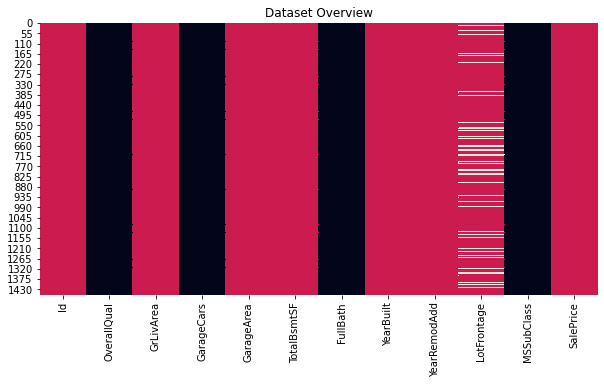

 Categerocial   Numerical   NaN 


In [6]:
dtf_overview(dtf, max_cat=20, figsize=(10,5))

In [7]:
dtf = dtf.set_index("Id")
dtf = dtf.rename(columns={"SalePrice":"Y"})

###### Group variables by type
- pk: Id
- y: SalePrice
- info: OverallQual, YearBuilt, YearRemodAdd, MSSubClass
- inside: GrLivArea, FullBath
- outside: LotFrontage
- perks: GarageCars, GarageArea, TotalBsmtSF

In [9]:
features = []

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


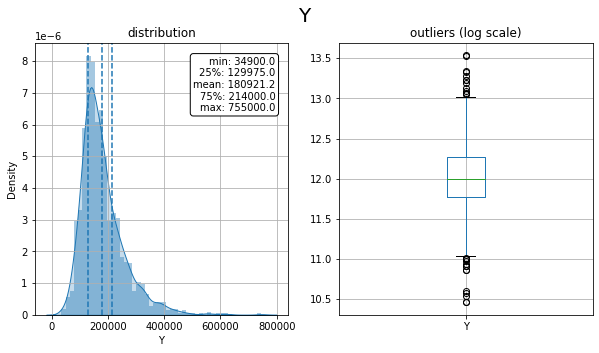

In [11]:
freqdist_plot(dtf, "Y", box_logscale=True, figsize=(10,5));

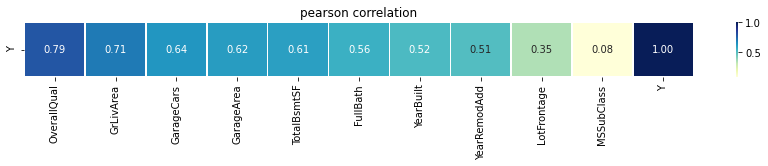

In [12]:
corr = corr_matrix(dtf, method="pearson", negative=False, lst_filters=["Y"], figsize=(15,1))

ValueError: ignored

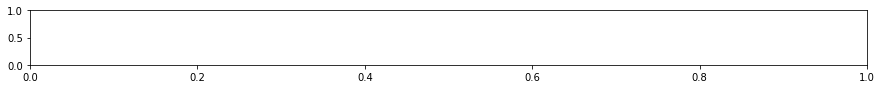

In [36]:
pps = pps_matrix(dtf, lst_filters=["Y"], figsize=(15,1))

In [35]:
def pps_matrix(dtf, annotation=True, lst_filters=[], figsize=(10,5)):
    dtf_pps = ppscore.matrix(dtf) if len(lst_filters) == 0 else ppscore.matrix(dtf).loc
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(dtf_pps, vmin=0., vmax=1., annot=annotation, fmt='.2f', cmap="YlGnBu", ax=ax, cbar=True, linewidths=0.5)
    plt.title("predictive power score")
    return dtf_pps

In [59]:
result = ppscore.matrix(dtf,sorted=True)
result[result.ppscore!=1.0][result.y == 'Y']

Boolean Series key will be reindexed to match DataFrame index.


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
13,OverallQual,Y,0.440962,regression,True,mean absolute error,55533.656164,31045.438267,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
21,GarageCars,Y,0.296431,regression,True,mean absolute error,55533.656164,39071.783929,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
34,YearBuilt,Y,0.198485,regression,True,mean absolute error,55533.656164,44511.073059,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
35,FullBath,Y,0.195689,regression,True,mean absolute error,55533.656164,44666.342882,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
38,GarageArea,Y,0.187993,regression,True,mean absolute error,55533.656164,45093.723468,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
48,YearRemodAdd,Y,0.143284,regression,True,mean absolute error,55533.656164,47576.566795,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
57,MSSubClass,Y,0.132175,regression,True,mean absolute error,55533.656164,48193.503265,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
61,GrLivArea,Y,0.100166,regression,True,mean absolute error,55533.656164,49971.091218,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
72,LotFrontage,Y,0.059992,regression,True,mean absolute error,58083.396336,54598.846066,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
76,TotalBsmtSF,Y,0.052363,regression,True,mean absolute error,55533.656164,52625.760798,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


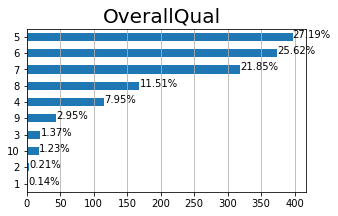

In [32]:
freqdist_plot(dtf, "OverallQual", figsize=(5,3))

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will

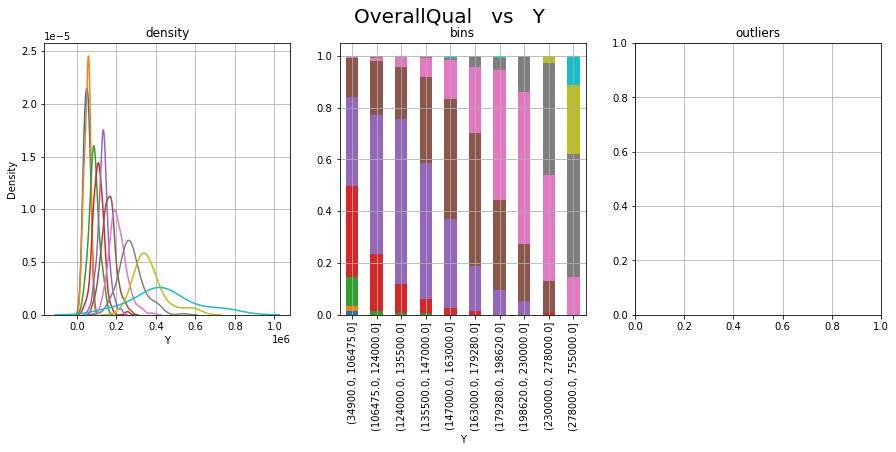

In [61]:
bivariate_plot(dtf, x="OverallQual", y="Y", figsize=(15,5));

In [62]:
features.append("OverallQual")

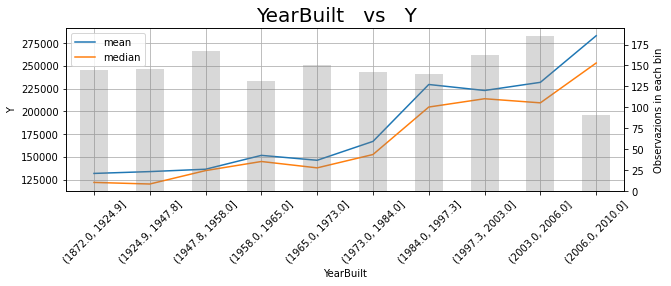

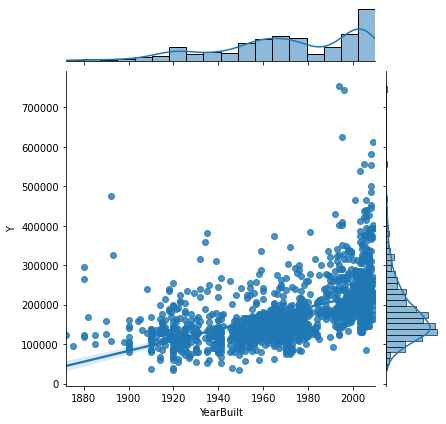

In [63]:
bivariate_plot(dtf, x="YearBuilt", y="Y", figsize=(10,3))

In [64]:
features.append("YearBuilt")

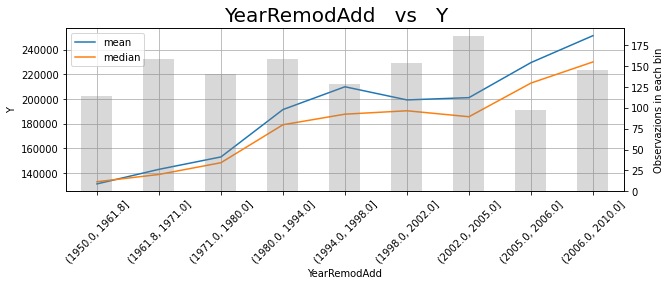

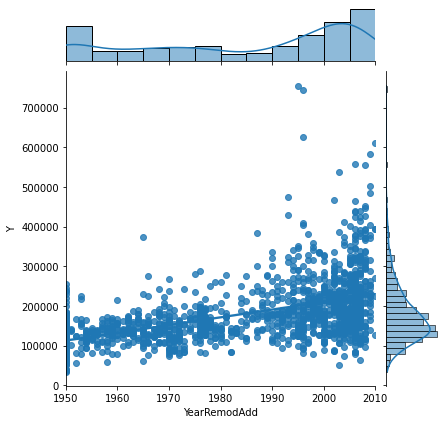

In [65]:
bivariate_plot(dtf, x="YearRemodAdd", y="Y", figsize=(10,3))

In [66]:
features.append("YearRemodAdd")

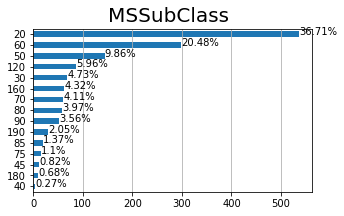

In [67]:
freqdist_plot(dtf, "MSSubClass", figsize=(5,3))

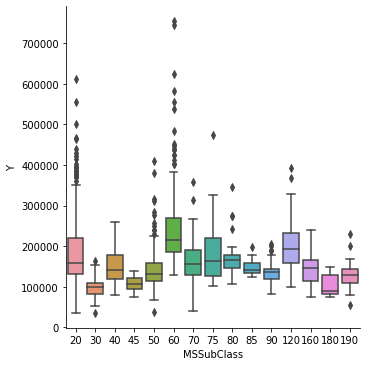

In [74]:
# this variable is tricky as it has 15 classes, so I will plot manually in one boxplot
sns.catplot(x="MSSubClass", y="Y", data=dtf, kind="box")

In [75]:
MSSubClass_clusters = {"min":[30,45,180], "max":[60,120], "mean":[]}
dtf = add_feature_clusters(dtf, "MSSubClass", dic_clusters_mapping=MSSubClass_clusters, dropx=False)
dtf[["MSSubClass","MSSubClass_cluster","Y"]].head()

,MSSubClass,MSSubClass_cluster,Y
Id,,,
1,60,max,208500
2,20,mean,181500
3,60,max,223500
4,70,mean,140000
5,60,max,250000


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
catplot is a figure-level function and does not accept target axes. You may wish to try boxplot


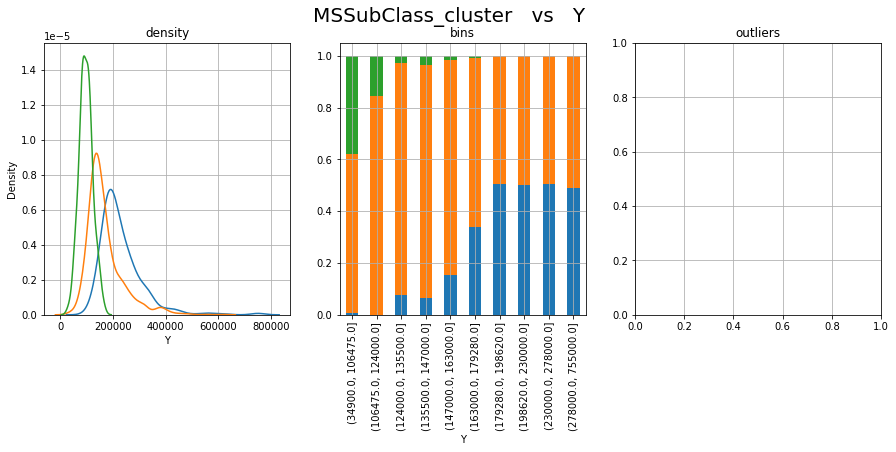

In [76]:
bivariate_plot(dtf, x="MSSubClass_cluster", y="Y", figsize=(15,5))

In [77]:
features.append("MSSubClass_cluster")

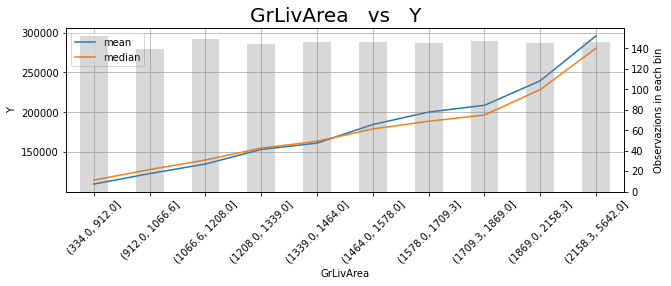

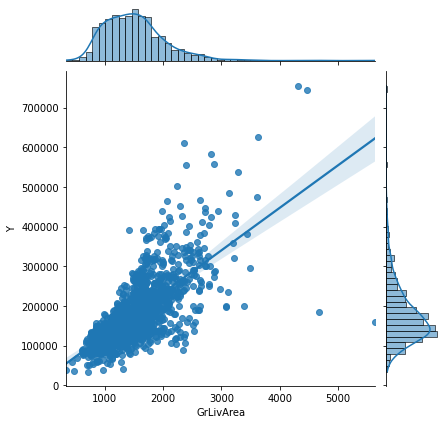

In [78]:
bivariate_plot(dtf, x="GrLivArea", y="Y", figsize=(10,3))

In [79]:
features.append("GrLivArea")

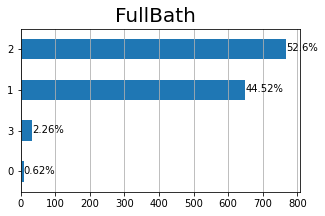

In [80]:
freqdist_plot(dtf, "FullBath", figsize=(5,3))

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
catplot is a figure-level function and does 

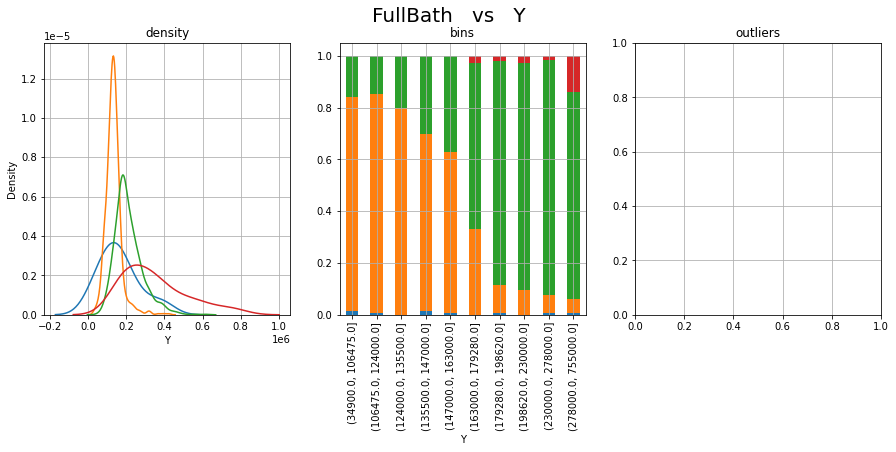

In [81]:
bivariate_plot(dtf, x="FullBath", y="Y", figsize=(15,5))

In [82]:
coeff, p = test_corr(dtf, x="FullBath", y="Y")

Anova F: the variables are Correlated (p-value: 0.0)


In [83]:
features.append("FullBath")

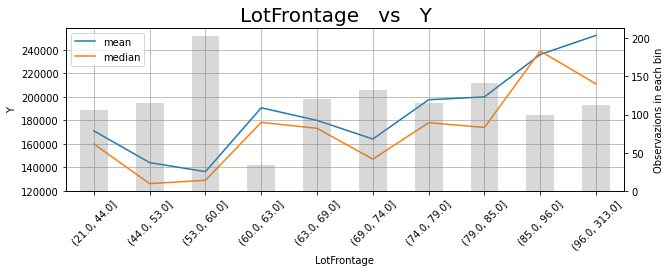

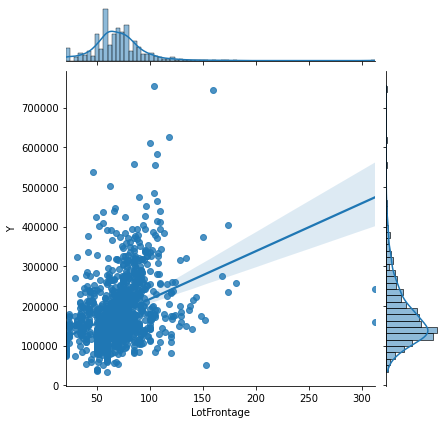

In [84]:
bivariate_plot(dtf, x="LotFrontage", y="Y", figsize=(10,3))

In [85]:
coeff, p = test_corr(dtf, x="LotFrontage", y="Y")

Pearson Correlation: 0.352 Significant (p-value: 0.0)


In [86]:
features.append("LotFrontage")

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will

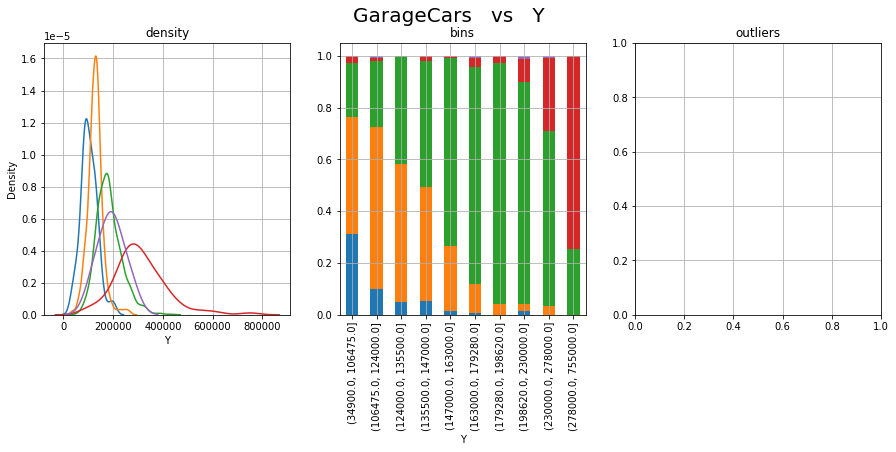

In [87]:
bivariate_plot(dtf, x="GarageCars", y="Y", figsize=(15,5))

In [88]:
features.append("GarageCars")

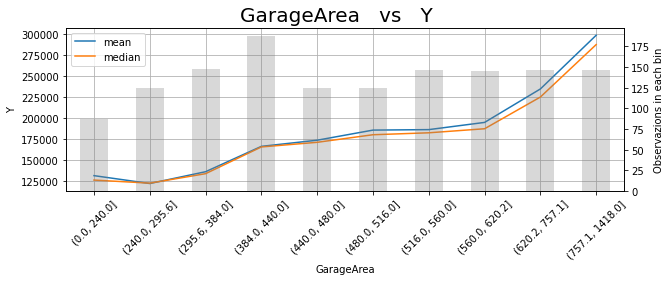

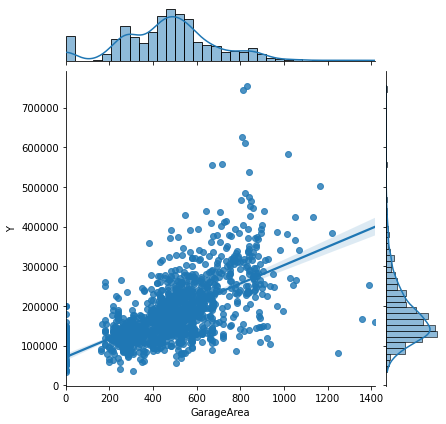

In [89]:
bivariate_plot(dtf, x="GarageArea", y="Y", figsize=(10,3))

In [90]:
features.append("GarageArea")

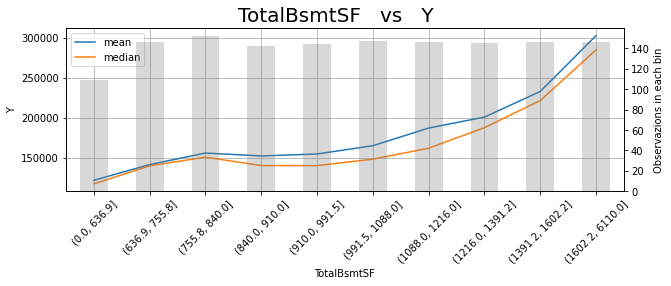

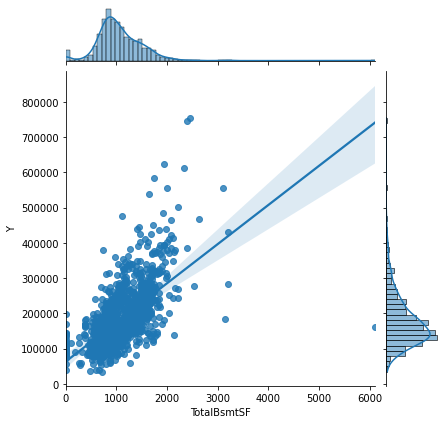

In [91]:
bivariate_plot(dtf, x="TotalBsmtSF", y="Y", figsize=(10,3))

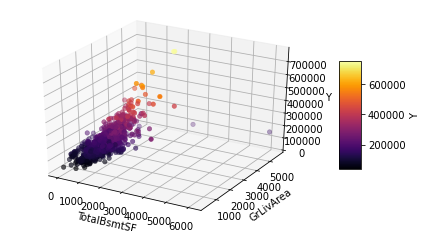

In [92]:
cross_distributions(dtf, x1="TotalBsmtSF", x2="GrLivArea", y="Y", figsize=(7,4))

In [93]:
features.append("TotalBsmtSF")

In [94]:
dtf = dtf[features+["Y"]]
dtf.head()

,OverallQual,YearBuilt,YearRemodAdd,MSSubClass_cluster,GrLivArea,FullBath,LotFrontage,GarageCars,GarageArea,TotalBsmtSF,Y
Id,,,,,,,,,,,
1,7,2003,2003,max,1710,2,65.0,2,548,856,208500
2,6,1976,1976,mean,1262,2,80.0,2,460,1262,181500
3,7,2001,2002,max,1786,2,68.0,2,608,920,223500
4,7,1915,1970,mean,1717,1,60.0,3,642,756,140000
5,8,2000,2000,max,2198,2,84.0,3,836,1145,250000


In [95]:
check = data_preprocessing(dtf, y="Y", task="regression")

--- check missing ---
--- check categorical data ---
--- split train/test ---
   OK: step skipped
--- scaling ---
   OK: step skipped


In [96]:
dtf_train, dtf_test = dtf_partitioning(dtf, y="Y", test_size=0.3, shuffle=False)

X_train shape: (1022, 10) | X_test shape: (438, 10)
y_train mean: 181713.25 | y_test mean: 179073.06
11 features: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MSSubClass_cluster', 'GrLivArea', 'FullBath', 'LotFrontage', 'GarageCars', 'GarageArea', 'TotalBsmtSF']


In [97]:
dtf_train.head(3)

,OverallQual,YearBuilt,YearRemodAdd,MSSubClass_cluster,GrLivArea,FullBath,LotFrontage,GarageCars,GarageArea,TotalBsmtSF,Y
Id,,,,,,,,,,,
1,7,2003,2003,max,1710,2,65.0,2,548,856,208500
2,6,1976,1976,mean,1262,2,80.0,2,460,1262,181500
3,7,2001,2002,max,1786,2,68.0,2,608,920,223500


In [98]:
dtf_test.head(3)

,OverallQual,YearBuilt,YearRemodAdd,MSSubClass_cluster,GrLivArea,FullBath,LotFrontage,GarageCars,GarageArea,TotalBsmtSF,Y
Id,,,,,,,,,,,
1023,5,1930,1950,mean,1248,1,52.0,1,160,912,87000
1024,7,2005,2006,max,1504,2,43.0,2,437,1346,191000
1025,8,1976,1976,mean,2898,2,NaN,2,665,1565,287000


In [99]:
dtf_train, lotfront_mean = fill_na(dtf_train, x="LotFrontage")

--- Replacing Nas with: 69.78579881656805 ---



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [100]:
dtf_train = add_dummies(dtf_train, x="MSSubClass_cluster", dropx=True)

   MSSubClass_cluster  MSSubClass_cluster_mean  MSSubClass_cluster_min
Id                                                                    
1                 max                        0                       0
2                mean                        1                       0
3                 max                        0                       0
4                mean                        1                       0
5                 max                        0                       0


In [101]:
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))

In [102]:
dtf_train, scalerX, scalerY = scaling(dtf_train, y="Y", scalerX=scalerX, scalerY=scalerY, task="regression")

In [103]:
dtf_train.head()

,OverallQual,YearBuilt,YearRemodAdd,GrLivArea,FullBath,LotFrontage,GarageCars,GarageArea,TotalBsmtSF,MSSubClass_cluster_mean,MSSubClass_cluster_min,Y
Id,,,,,,,,,,,,
1,0.5,0.617021,0.243243,0.395177,0.0,-0.265878,0.0,0.283333,-0.293889,-1.0,0.0,0.526684
2,0.0,0.042553,-0.486486,-0.301828,0.0,0.567456,0.0,-0.083333,0.493695,0.0,0.0,0.208944
3,0.5,0.574468,0.216216,0.513419,0.0,-0.099211,0.0,0.533333,-0.169738,-1.0,0.0,0.703207
4,0.5,-1.255319,-0.648649,0.406068,-1.0,-0.543655,1.0,0.675000,-0.487876,0.0,0.0,-0.279435
5,1.0,0.553191,0.162162,1.154415,0.0,0.789678,1.0,1.483333,0.266731,-1.0,0.0,1.015063


Shape: (1022, 12)
-----------------
OverallQual --> Type:cat | Nas: 0(0%) | Categories: 10
YearBuilt --> Type:num | Nas: 0(0%) | Min-Max: (-2)-(0)
YearRemodAdd --> Type:num | Nas: 0(0%) | Min-Max: (-1)-(0)
GrLivArea --> Type:num | Nas: 0(0%) | Min-Max: (-1)-(5)
FullBath --> Type:cat | Nas: 0(0%) | Categories: 4
LotFrontage --> Type:num | Nas: 0(0%) | Min-Max: (-2)-(13)
GarageCars --> Type:cat | Nas: 0(0%) | Categories: 5
GarageArea --> Type:num | Nas: 0(0%) | Min-Max: (-2)-(3)
TotalBsmtSF --> Type:num | Nas: 0(0%) | Min-Max: (-1)-(4)
MSSubClass_cluster_mean --> Type:cat | Nas: 0(0%) | Categories: 2
MSSubClass_cluster_min --> Type:cat | Nas: 0(0%) | Categories: 2
Y --> Type:num | Nas: 0(0%) | Min-Max: (-1)-(6)


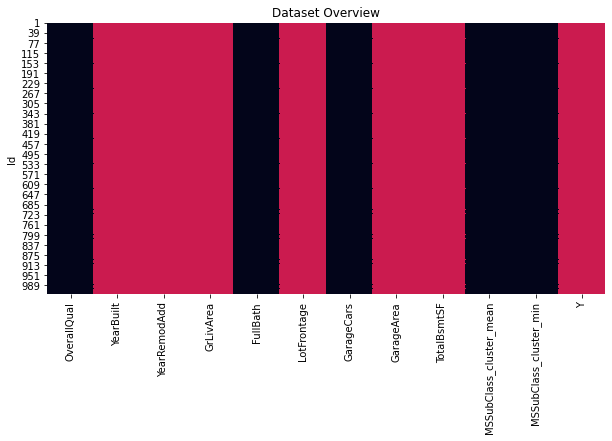

 Categerocial   Numerical   NaN 


In [104]:
dtf_overview(dtf_train)